In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from prettytable import PrettyTable

from algorithms import NewtonsMethodOptimizer, GlobalizedNewtonsOptimizer, QuasiNewtonBFGSOptimizer, LBFGSOptimizer
from algorithms import SubsamplingNewton,StochasticBFGS, StochasticLBFGS

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

warnings.filterwarnings("ignore")

In [2]:
def function(w):
    return 2 * (w[0] + w[1] + w[2] - 3) ** 2 + (w[0] - w[1]) ** 2 + (w[1] - w[2]) ** 2


def grad(w):
    return np.array(
        [6 * w[0] + 2 * w[1] + 4 * w[2] - 12, 2 * w[0] + 8 * w[1] + 2 * w[2] - 12, 4 * w[0] + 2 * w[1] + 6 * w[2] - 12])


def hess(w):
    return np.array([[6, 2, 4], [2, 8, 2], [4, 2, 6]])


def rosenbrock(w):
    return 100 * (w[1] - w[0] ** 2) ** 2 + (1 - w[0]) ** 2


def grad_rosenbrock(w):
    return np.array([
        -400 * w[0] * (w[1] - w[0] ** 2) - 2 * (1 - w[0]),
        200 * (w[1] - w[0] ** 2)
    ])


def hess_rosenbrock(w):
    return np.array([
        [800 * w[0] ** 2 - 400 * (w[1] - w[0] ** 2) + 2, -400 * w[0]],
        [-400 * w[0], 200]
    ])

In [3]:
initial_points = [np.array([0, 0, 0]), np.array([-1, 2, -1]), np.array([2, -1, 3]), np.array([1, 1, 1]),
                  np.array([1.5, 1.5, 2.5])]
result = []
for initial_point in initial_points:
    optimizer = NewtonsMethodOptimizer(function, grad, hess, initial_point, verbose=False)
    final_point, stats = optimizer.solve()
    result.append((final_point, stats))

table = PrettyTable()
table.field_names = ["Initial Point", "Final Point", "Iterations", "Error Messages"]
for (final_point, stats), initial_point in zip(result, initial_points):
    table.add_row([initial_point, final_point, stats['iterations'], stats['error_messages']])
print(table)

+---------------+-------------+------------+----------------+
| Initial Point | Final Point | Iterations | Error Messages |
+---------------+-------------+------------+----------------+
|    [0 0 0]    |  [1. 1. 1.] |     1      |       []       |
|   [-1  2 -1]  |  [1. 1. 1.] |     1      |       []       |
|   [ 2 -1  3]  |  [1. 1. 1.] |     1      |       []       |
|    [1 1 1]    |  [1. 1. 1.] |     1      |       []       |
| [1.5 1.5 2.5] |  [1. 1. 1.] |     1      |       []       |
+---------------+-------------+------------+----------------+


In [4]:
initial_points = [np.array([-1.2, 1]), np.array([0, 0.005])]
newton_a = NewtonsMethodOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[0], verbose=False)
final_point_a, stats_a = newton_a.solve()
newton_b = NewtonsMethodOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[1], verbose=False)
final_point_b, stats_b = newton_b.solve()

table = PrettyTable()
table.field_names = ["Algorithm", "Initial Point", "Final Point", "Iterations", "Error Messages"]
table.add_row(
    ["Newton's Method", initial_points[0], final_point_a, stats_a['iterations'], stats_a['error_messages']])
table.add_row(
    ["Newton's Method", initial_points[1], final_point_b, stats_b['iterations'], stats_b['error_messages']])
print(table)

+-----------------+---------------+-------------------------+------------+---------------------+
|    Algorithm    | Initial Point |       Final Point       | Iterations |    Error Messages   |
+-----------------+---------------+-------------------------+------------+---------------------+
| Newton's Method |  [-1.2  1. ]  | [0.9999957  0.99999139] |     5      |          []         |
| Newton's Method | [0.    0.005] |      [0.    0.005]      |     0      | ['Singular matrix'] |
+-----------------+---------------+-------------------------+------------+---------------------+


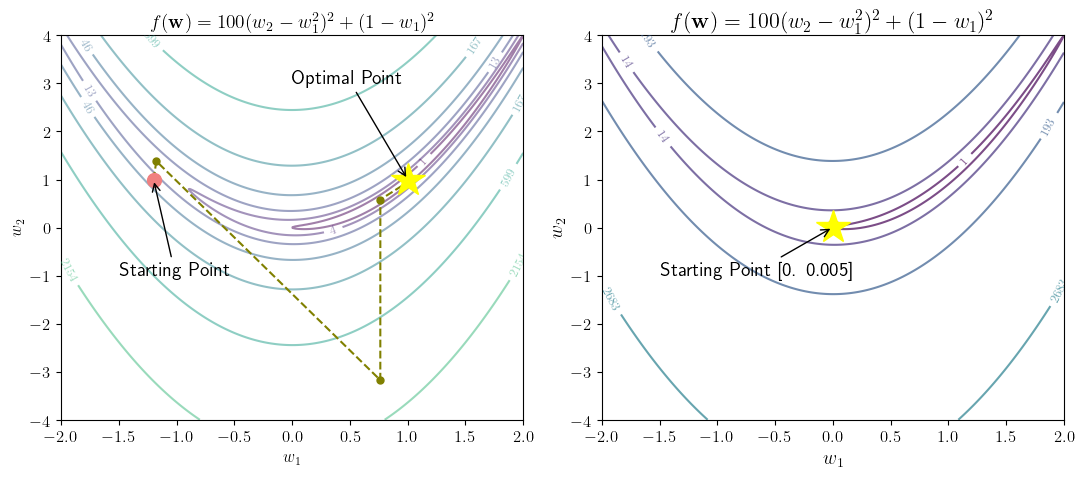

In [5]:
trajectory_a = np.array(stats_a['trajectory'])
trajectory_b = np.array(stats_b['trajectory'])

x = np.linspace(-2, 2, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

levels_log_space = np.logspace(0, 5, 10)
cmap_choice = 'viridis'
contour_line_opts = {'linewidths': 0.5, 'colors': 'black'}
contour_label_opts = {'inline': True, 'fontsize': 9}

contour1 = ax[0].contour(X, Y, Z, levels=levels_log_space, norm=LogNorm(), cmap=cmap_choice, alpha=0.5)
ax[0].clabel(contour1, **contour_label_opts)
ax[0].plot(*trajectory_a.T, 'o--', color='olive', markersize=5, label='Trajectory')
ax[0].plot(*trajectory_a[0], 'o', color='lightcoral', markersize=10, label='Starting Point')
ax[0].plot(*final_point_a, '*', color='yellow', markersize=25, label='Optimal Point')
ax[0].annotate('Starting Point', xy=trajectory_a[0], xytext=(-1.5, -1),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[0].annotate('Optimal Point', xy=final_point_a, xytext=(0, 3),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[0].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=14)
ax[0].set_xlabel('$w_1$', fontsize=12)
ax[0].set_ylabel('$w_2$', fontsize=12)

contour2 = ax[1].contour(X, Y, Z, levels=np.logspace(0, 8, 8), norm=LogNorm(), cmap=cmap_choice, alpha=0.7)
ax[1].clabel(contour2, **contour_label_opts)
ax[1].plot(*trajectory_b.T, 'o--', color='olive', markersize=5, label='Trajectory')
ax[1].plot(*trajectory_b[0], 'o', color='lightcoral', markersize=10, label='Starting Point')
ax[1].plot(*final_point_b, '*', color='yellow', markersize=25, label='Optimal Point')
ax[1].annotate(f'Starting Point {initial_points[1]}', xy=trajectory_b[0], xytext=(-1.5, -1),
               arrowprops=dict(facecolor='black', arrowstyle='->'))
ax[1].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=16)
ax[1].set_xlabel('$w_1$', fontsize=14)
ax[1].set_ylabel('$w_2$', fontsize=14)

plt.tight_layout()
plt.savefig('./figures/rosenbrock.pdf', bbox_inches='tight')
plt.show()

In [6]:
glnewton_a = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[0], verbose=False,
                                        c=0.0001, theta=0.5)
glnewton_b = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_points[1], verbose=False,
                                        c=0.0001, theta=0.5)

final_point_a, stats_a = glnewton_a.solve()
final_point_b, stats_b = glnewton_b.solve()

trajectory_a = np.array(stats_a['trajectory'])
trajectory_b = np.array(stats_b['trajectory'])

table = PrettyTable()
table.field_names = ["Algorithm", "Initial Point", "Final Point", "Iterations", "Error Messages"]
table.add_row(
    ["Globalized Newton's Method", initial_points[0], final_point_a, stats_a['iterations'], stats_a['error_messages']])
table.add_row(
    ["Globalized Newton's Method", initial_points[1], final_point_b, stats_b['iterations'], stats_b['error_messages']])
print(table)

+----------------------------+---------------+-------------------------+------------+----------------+
|         Algorithm          | Initial Point |       Final Point       | Iterations | Error Messages |
+----------------------------+---------------+-------------------------+------------+----------------+
| Globalized Newton's Method |  [-1.2  1. ]  |         [1. 1.]         |     21     |       []       |
| Globalized Newton's Method | [0.    0.005] | [0.99999988 0.99999974] |     13     |       []       |
+----------------------------+---------------+-------------------------+------------+----------------+


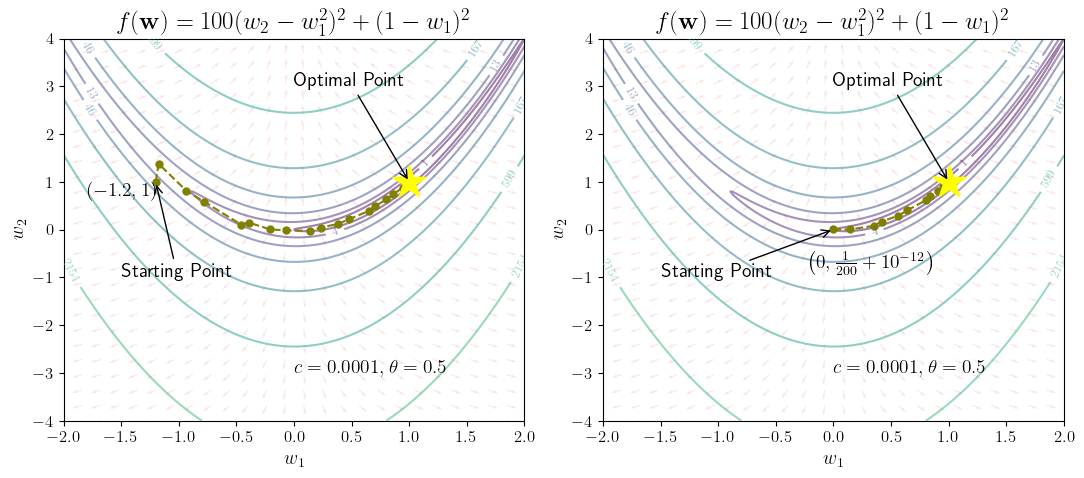

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
x = np.linspace(-2, 2, 500)
y = np.linspace(-4, 4, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

U, V = np.zeros(X.shape), np.zeros(Y.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        grad = grad_rosenbrock(np.array([X[i, j], Y[i, j]]))
        U[i, j] = grad[0]
        V[i, j] = grad[1]

norm = np.sqrt(U ** 2 + V ** 2)
U, V = U / norm, V / norm
quiver_skip = 20

trajectories = [(trajectory_a, final_point_a, initial_points[0]), (trajectory_b, final_point_b, initial_points[1])]
for i, (trajectory, final_point, initial_point) in enumerate(trajectories):
    contour = ax[i].contour(X, Y, Z, levels=np.logspace(0, 5, 10), norm=LogNorm(), cmap='viridis', alpha=0.5)
    ax[i].clabel(contour, inline=True, fontsize=9)
    ax[i].plot([pt[0] for pt in trajectory], [pt[1] for pt in trajectory], 'o--', color='olive', markersize=5)
    ax[i].plot(final_point[0], final_point[1], '*', color='yellow', markersize=25)
    ax[i].annotate('Starting Point', xy=initial_point, xytext=(-1.5, -1),
                   arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax[i].annotate('Optimal Point', xy=final_point, xytext=(0, 3),
                   arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax[i].quiver(X[::quiver_skip, ::quiver_skip], Y[::quiver_skip, ::quiver_skip],
                 U[::quiver_skip, ::quiver_skip], V[::quiver_skip, ::quiver_skip],
                 color='lightcoral', alpha=0.2, scale=45, zorder=1)

    ax[i].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=18)
    ax[i].set_xlabel('$w_1$')
    ax[i].set_ylabel('$w_2$')

ax[0].annotate(r'$c=0.0001, \theta=0.5$', xy=(0, -3), xytext=(0, -3), fontsize=14)
ax[0].annotate(r'$\left(-1.2, 1\right)$', xy=(-1.2, 1), xytext=(-1.8, 0.7), fontsize=14)
ax[1].annotate(r'$c=0.0001, \theta=0.5$', xy=(0, -3), xytext=(0, -3), fontsize=14)
ax[1].annotate(r'$\left(0, \frac{1}{200} + 10^{-12}\right)$', xy=(0, 0.005), xytext=(-0.2, -0.8), fontsize=14)

plt.tight_layout()
plt.savefig('./figures/rosenbrock_globalized.pdf', bbox_inches='tight')
plt.show()

In [8]:
initial_point = np.array([0, 0.005])
c = [0.0001, 0.001, 0.01, 0.1, 0.5]
results_c = {}
for value in c:
    glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_point, verbose=False,
                                          c=value, theta=0.5)
    final_point, stats = glnewton.solve()
    results_c[value] = (final_point, stats)

theta = [0.1, 0.3, 0.5, 0.7, 0.9]
results_theta = {}
for value in theta:
    glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, initial_point, verbose=False,
                                          c=0.0001, theta=value)
    final_point, stats = glnewton.solve()
    results_theta[value] = (final_point, stats)
    
table = PrettyTable()
table.field_names = ["c", "Iterations", "Initial Point", "Final Point"]
for c_value, (final_point, stats) in results_c.items():
    table.add_row([c_value, stats['iterations'], initial_point, final_point])
print(table)

table = PrettyTable()
table.field_names = ["theta", "Iterations", "Initial Point", "Final Point"]
for theta_value, (final_point, stats) in results_theta.items():
    table.add_row([theta_value, stats['iterations'], initial_point, final_point])
print(table)

+--------+------------+---------------+-------------------------+
|   c    | Iterations | Initial Point |       Final Point       |
+--------+------------+---------------+-------------------------+
| 0.0001 |     13     | [0.    0.005] | [0.99999988 0.99999974] |
| 0.001  |     13     | [0.    0.005] | [0.99999988 0.99999974] |
|  0.01  |     13     | [0.    0.005] | [0.99999988 0.99999974] |
|  0.1   |     13     | [0.    0.005] | [0.99999988 0.99999974] |
|  0.5   |     14     | [0.    0.005] | [0.99999996 0.99999991] |
+--------+------------+---------------+-------------------------+
+-------+------------+---------------+-------------------------+
| theta | Iterations | Initial Point |       Final Point       |
+-------+------------+---------------+-------------------------+
|  0.1  |     30     | [0.    0.005] | [0.99999688 0.99999375] |
|  0.3  |     13     | [0.    0.005] | [0.99999908 0.99999815] |
|  0.5  |     13     | [0.    0.005] | [0.99999988 0.99999974] |
|  0.7  |     12

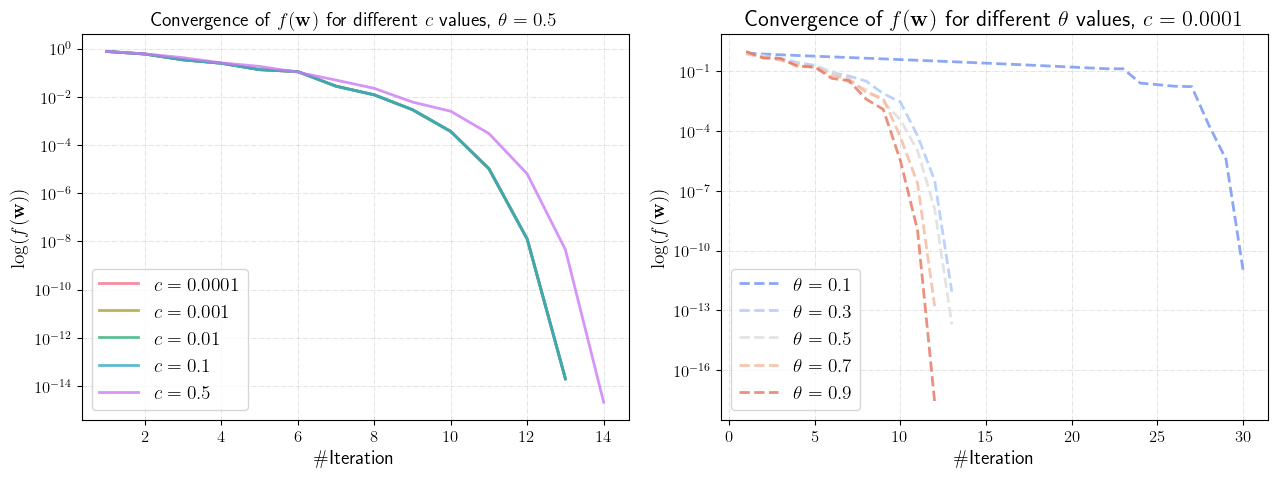

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
colors = sns.color_palette("husl", len(c))
theta_colors = sns.color_palette("coolwarm", len(theta))

for result, c_value, color in zip(results_c.values(), c, colors):
    ax[0].plot([iteration for iteration in range(1, len(result[1]['function_values']) + 1)],
               result[1]['function_values'],
               label=f"$c={c_value}$", linestyle='-', linewidth=2, alpha=0.8, color=color)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'\#Iteration')
ax[0].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[0].set_title(r'Convergence of $f(\mathbf{w})$ for different $c$ values, $\theta=0.5$', fontsize=14)
ax[0].legend(fontsize=14, loc='lower left')

for result, theta_value, color in zip(results_theta.values(), theta, theta_colors):
    ax[1].plot([iteration for iteration in range(1, len(result[1]['function_values']) + 1)],
               result[1]['function_values'],
               label=f"$\\theta={theta_value}$", linestyle='--', linewidth=2, alpha=0.8, color=color)
ax[1].set_yscale('log')
ax[1].set_xlabel(r'\#Iteration')
ax[1].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[1].set_title(r'Convergence of $f(\mathbf{w})$ for different $\theta$ values, $c=0.0001$', fontsize=16)
ax[1].legend(fontsize=14, loc='lower left')

for axis in ax:
    axis.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('./figures/rosenbrock_globalized_c_theta.pdf', bbox_inches='tight')
plt.show()

In [10]:
## RECALL PROBLEM 3

def function(w):
    return 2 * (w[0] + w[1] + w[2] - 3) ** 2 + (w[0] - w[1]) ** 2 + (w[1] - w[2]) ** 2


def grad(w):
    return np.array(
        [6 * w[0] + 2 * w[1] + 4 * w[2] - 12, 2 * w[0] + 8 * w[1] + 2 * w[2] - 12, 4 * w[0] + 2 * w[1] + 6 * w[2] - 12])


def hess(w):
    return np.array([[6, 2, 4], [2, 8, 2], [4, 2, 6]])


start_point = np.array([0, 0, 0])
bgfs = QuasiNewtonBFGSOptimizer(function, grad, start_point, c=0.0001, theta=0.5, verbose=False)
glnewton = GlobalizedNewtonsOptimizer(function, grad, hess, start_point, c=0.0001, theta=0.5, verbose=False)

_, _ = bgfs.solve()
_, _ = glnewton.solve()

In [11]:
start_point = np.array([-1.2, 1])
bgfs = QuasiNewtonBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, c=0.0001, theta=0.5, verbose=False)
glnewton = GlobalizedNewtonsOptimizer(rosenbrock, grad_rosenbrock, hess_rosenbrock, start_point, c=0.0001, theta=0.5,
                                      verbose=False)

final_point_bgfs, stats_bgfs = bgfs.solve()
final_point_glnewton, stats_glnewton = glnewton.solve()

table = PrettyTable()
table.field_names = ["Algorithm", "Iterations", "Initial Point", "Final Point"]
table.add_row(["BFGS", stats_bgfs['iterations'], start_point, final_point_bgfs])
table.add_row(["Globalized Newton's Method", stats_glnewton['iterations'], start_point,
               final_point_glnewton])
print(table)

+----------------------------+------------+---------------+-------------------------+
|         Algorithm          | Iterations | Initial Point |       Final Point       |
+----------------------------+------------+---------------+-------------------------+
|            BFGS            |     33     |  [-1.2  1. ]  | [0.99999966 0.99999928] |
| Globalized Newton's Method |     21     |  [-1.2  1. ]  |         [1. 1.]         |
+----------------------------+------------+---------------+-------------------------+


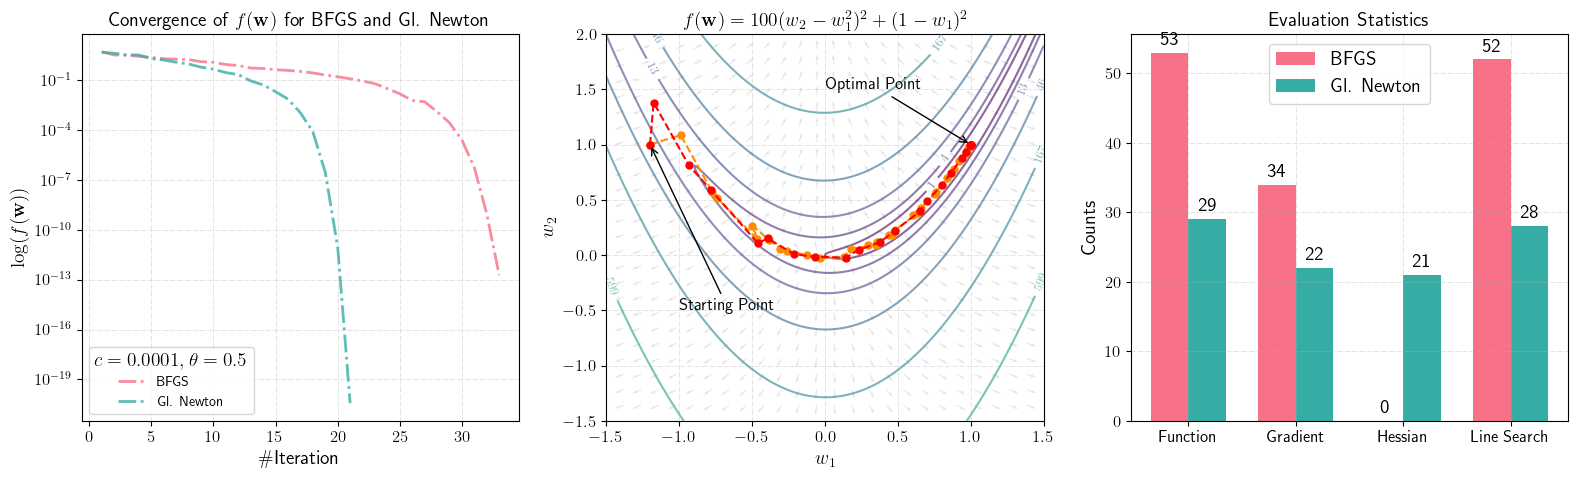

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
colors = sns.color_palette("husl", 2)

for result, method, color in zip([stats_bgfs, stats_glnewton], ['BFGS', 'Gl. Newton'], colors):
    ax[0].plot([iteration for iteration in range(1, len(result['function_values']) + 1)],
               result['function_values'],
               label=method, linestyle='-.', linewidth=2, alpha=0.8, color=color)
ax[0].set_yscale('log')
ax[0].set_xlabel(r'\#Iteration')
ax[0].set_ylabel(r'$\log(f(\mathbf{w}))$')
ax[0].set_title(r'Convergence of $f(\mathbf{w})$ for BFGS and Gl. Newton', fontsize=14)
ax[0].legend(fontsize=10, loc='lower left', title=r'$c=0.0001, \theta=0.5$')

x = np.linspace(-1.5, 1.5, 500)
y = np.linspace(-1.5, 2, 500)
X, Y = np.meshgrid(x, y)
Z = 100 * (Y - X ** 2) ** 2 + (1 - X) ** 2

U, V = np.zeros(X.shape), np.zeros(Y.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        grad = grad_rosenbrock(np.array([X[i, j], Y[i, j]]))
        U[i, j] = grad[0]
        V[i, j] = grad[1]

norm = np.sqrt(U ** 2 + V ** 2)
U /= norm
V /= norm
quiver_skip = 20

contour = ax[1].contour(X, Y, Z, levels=np.logspace(0, 5, 10), norm=LogNorm(), cmap='viridis', alpha=0.6)
ax[1].clabel(contour, inline=True, fontsize=9)
ax[1].plot([x[0] for x in stats_bgfs['trajectory']], [x[1] for x in stats_bgfs['trajectory']], 'o--',
           color='darkorange', markersize=5, label='BFGS')
ax[1].plot([x[0] for x in stats_glnewton['trajectory']], [x[1] for x in stats_glnewton['trajectory']], 'o--',
           color='red', markersize=5, label='Gl. Newton')
ax[1].quiver(X[::quiver_skip, ::quiver_skip], Y[::quiver_skip, ::quiver_skip],
             U[::quiver_skip, ::quiver_skip], V[::quiver_skip, ::quiver_skip],
             color='grey', alpha=0.2, scale=45, zorder=1)
ax[1].annotate('Starting Point', xy=start_point, xytext=(-1, -0.5),
               arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax[1].annotate('Optimal Point', xy=final_point_bgfs, xytext=(0, 1.5),
               arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
ax[1].set_title(r"$f(\mathbf{w}) = 100(w_2 - w_1^2)^2 + (1 - w_1)^2$", fontsize=14)
ax[1].set_xlabel('$w_1$')
ax[1].set_ylabel('$w_2$')
for axis in ax:
    axis.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

stats_categories = ['Function', 'Gradient', 'Hessian', 'Line Search']
x = np.arange(len(stats_categories))
width = 0.35

stats_bfgs = [stats_bgfs['function_evaluations'], stats_bgfs['gradient_evaluations'], 0, stats_bgfs['line_search_step']]

stats_newton = [stats_glnewton['function_evaluations'], stats_glnewton['gradient_evaluations'],
                stats_glnewton['hessian_evaluations'], stats_glnewton['line_search_step']]

rects1 = ax[2].bar(x - width / 2, stats_bfgs, width, label='BFGS', color=colors[0])
rects2 = ax[2].bar(x + width / 2, stats_newton, width, label='Gl. Newton', color=colors[1])

ax[2].set_ylabel('Counts')
ax[2].set_title('Evaluation Statistics')
ax[2].set_xticks(x)
ax[2].set_xticklabels(stats_categories, fontsize=12)
ax[2].legend()


def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, ax[2])
autolabel(rects2, ax[2])

plt.tight_layout()
plt.savefig('./figures/rosenbrock_bfgs_vs_newton.pdf', bbox_inches='tight')
plt.show()

In [13]:
start_point = np.array([-1.2, 1])
c, theta, tolerance, max_iterations = 0.0001, 0.5, 1e-4, 10000

bfgs = QuasiNewtonBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, c=c, theta=theta, verbose=False)
lbfgs_0 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=0, c=c, theta=theta, verbose=False)
lbfgs_1 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=1, c=c, theta=theta, verbose=False)
lbfgs_5 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=5, c=c, theta=theta, verbose=False)
lbfgs_10 = LBFGSOptimizer(rosenbrock, grad_rosenbrock, start_point, memory_size=10, c=c, theta=theta, verbose=False)

final_point_bfgs, stats_bfgs = bfgs.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_0, stats_lbfgs_0 = lbfgs_0.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_1, stats_lbfgs_1 = lbfgs_1.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_5, stats_lbfgs_5 = lbfgs_5.solve(tolerance=tolerance, max_iterations=max_iterations)
final_point_lbfgs_10, stats_lbfgs_10 = lbfgs_10.solve(tolerance=tolerance, max_iterations=max_iterations)

In [14]:
table = PrettyTable()
table.field_names = ["Optimizer", "Function Evaluations", "Gradient Evaluations",
                     "Line Search Steps", "Iterations"]

table.add_row(["BFGS", stats_bfgs['function_evaluations'], stats_bfgs['gradient_evaluations'],
               stats_bfgs['line_search_step'], stats_bfgs['iterations']])
table.add_row(["L-BFGS (m=0)", stats_lbfgs_0['function_evaluations'], stats_lbfgs_0['gradient_evaluations'],
               stats_lbfgs_0['line_search_step'], stats_lbfgs_0['iterations']])
table.add_row(["L-BFGS (m=1)", stats_lbfgs_1['function_evaluations'], stats_lbfgs_1['gradient_evaluations'],
               stats_lbfgs_1['line_search_step'], stats_lbfgs_1['iterations']])
table.add_row(["L-BFGS (m=5)", stats_lbfgs_5['function_evaluations'], stats_lbfgs_5['gradient_evaluations'],
               stats_lbfgs_5['line_search_step'], stats_lbfgs_5['iterations']])
table.add_row(["L-BFGS (m=10)", stats_lbfgs_10['function_evaluations'], stats_lbfgs_10['gradient_evaluations'],
               stats_lbfgs_10['line_search_step'], stats_lbfgs_10['iterations']])
print("Comparison of BFGS and L-BFGS Optimizers for Rosenbrock Function")
print(table)

table = PrettyTable()
table.field_names = ["Optimizer", "Initial Point", "Final Point", "Iterations", "Error Messages"]
table.add_row(["BFGS", start_point, final_point_bfgs, stats_bfgs['iterations'], stats_bfgs['error_messages']])
table.add_row(
    ["L-BFGS (m=0)", start_point, final_point_lbfgs_0, stats_lbfgs_0['iterations'], stats_lbfgs_0['error_messages']])
table.add_row(
    ["L-BFGS (m=1)", start_point, final_point_lbfgs_1, stats_lbfgs_1['iterations'], stats_lbfgs_1['error_messages']])
table.add_row(
    ["L-BFGS (m=5)", start_point, final_point_lbfgs_5, stats_lbfgs_5['iterations'], stats_lbfgs_5['error_messages']])
table.add_row(["L-BFGS (m=10)", start_point, final_point_lbfgs_10, stats_lbfgs_10['iterations'],
               stats_lbfgs_10['error_messages']])
print(table)

Comparison of BFGS and L-BFGS Optimizers for Rosenbrock Function
+---------------+----------------------+----------------------+-------------------+------------+
|   Optimizer   | Function Evaluations | Gradient Evaluations | Line Search Steps | Iterations |
+---------------+----------------------+----------------------+-------------------+------------+
|      BFGS     |          53          |          34          |         52        |     33     |
|  L-BFGS (m=0) |        80045         |         8059         |       80044       |    8058    |
|  L-BFGS (m=1) |         368          |          43          |        367        |     42     |
|  L-BFGS (m=5) |          65          |          36          |         64        |     35     |
| L-BFGS (m=10) |          52          |          33          |         51        |     32     |
+---------------+----------------------+----------------------+-------------------+------------+
+---------------+---------------+-------------------------+---

In [15]:
from regpb import RegPb, simu_linmodel

d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

np.random.seed(0)

w_model_truth = (-1) ** idx * np.exp(-idx / 10.)

Xlin, ylin = simu_linmodel(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_linmodel(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog)

pblinreg = RegPb(Xlin, ylin, lbda, loss='l2')
pblogreg = RegPb(Xlog, ylog, lbda, loss='logit')

In [16]:
objective_fn = pblogreg.fun
gradient_fn = pblogreg.grad
hessian_fn = pblogreg.hess

In [17]:
initial_point = np.zeros(d)
newton = NewtonsMethodOptimizer(objective_fn, gradient_fn, hessian_fn, initial_point, verbose=False)
final_point, stats = newton.solve(tolerance=1e-6, max_iterations=1000)

table = PrettyTable()
table.field_names = ["Algorithm", "Iterations", "Function Value"]
table.add_row(["Newton's Method", stats['iterations'], stats['function_values'][-1]])
print(table)

+-----------------+------------+--------------------+
|    Algorithm    | Iterations |   Function Value   |
+-----------------+------------+--------------------+
| Newton's Method |     3      | 0.5621593875955311 |
+-----------------+------------+--------------------+


In [18]:
problem = pblogreg
sample_size_grad = sample_size_hess = 128

newton = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4, alpha=0.01,
                           verbose=False)
final_point = newton.optimize(initial_point, tol=1e-6, use_line_search=False)

table = PrettyTable()
table.field_names = ["Algorithm", "Epochs", "Function Value"]
table.add_row(["Subsampling Newton", newton.stats['epochs'][-1], newton.stats['losses'][-1]])
print(table)

+--------------------+--------+--------------------+
|     Algorithm      | Epochs |   Function Value   |
+--------------------+--------+--------------------+
| Subsampling Newton |  200   | 0.5631689025712563 |
+--------------------+--------+--------------------+


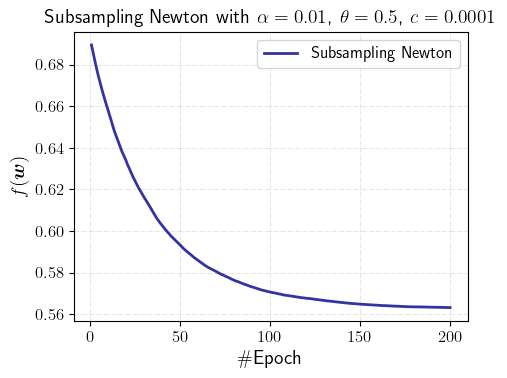

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(newton.stats['epochs'], newton.stats['losses'],
        label='Subsampling Newton', linestyle='-', linewidth=2, alpha=0.8, color='darkblue')
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Subsampling Newton with $\alpha={}$, $\theta={}$, $c={}$'.format(newton.alpha, newton.theta, newton.c))
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton.pdf', bbox_inches='tight')
plt.show()

In [20]:
sample_sizes = [16, 32, 64, 128, 256]
results = {}
for sample_size in sample_sizes:
    newton = SubsamplingNewton(problem, sample_size, sample_size, epochs=200, theta=0.5, c=1e-4, alpha=0.01)
    final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
    results[sample_size] = (final_point, stats)

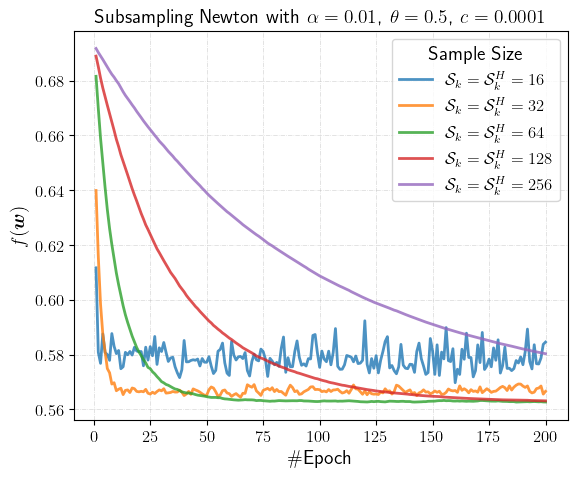

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for sample_size, (final_point, stats) in results.items():
    ax.plot(stats['epochs'], stats['losses'],
            label=r"$\mathcal{{S}}_{{k}}=\mathcal{{S}}_{{k}}^{{H}}={}$".format(sample_size),
            linestyle='-', linewidth=2, alpha=0.8)
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Subsampling Newton with $\alpha={}$, $\theta={}$, $c={}$'.format(newton.alpha, newton.theta, newton.c))
ax.legend(fontsize=12, title='Sample Size')
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton_sample_sizes.pdf', bbox_inches='tight')
plt.show()

In [22]:
# TIME CONSUMING ETA 14min FOR ALL COMBINATIONS

sample_size_grad = [32, 64, 128, 256]
sample_size_hess = [32, 64, 128, 256]

results_diff_grad_32, results_diff_grad_64, results_diff_grad_128, results_diff_grad_256 = {}, {}, {}, {}
for size_grad in sample_size_grad:
    for size_hess in sample_size_hess:
        if size_grad != size_hess:
            newton = SubsamplingNewton(problem, size_grad, size_hess, epochs=200, theta=0.5, c=1e-4, alpha=0.01)
            final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
            if size_grad == 32:
                results_diff_grad_32[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 64:
                results_diff_grad_64[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 128:
                results_diff_grad_128[(size_grad, size_hess)] = (final_point, stats)
            elif size_grad == 256:
                results_diff_grad_256[(size_grad, size_hess)] = (final_point, stats)

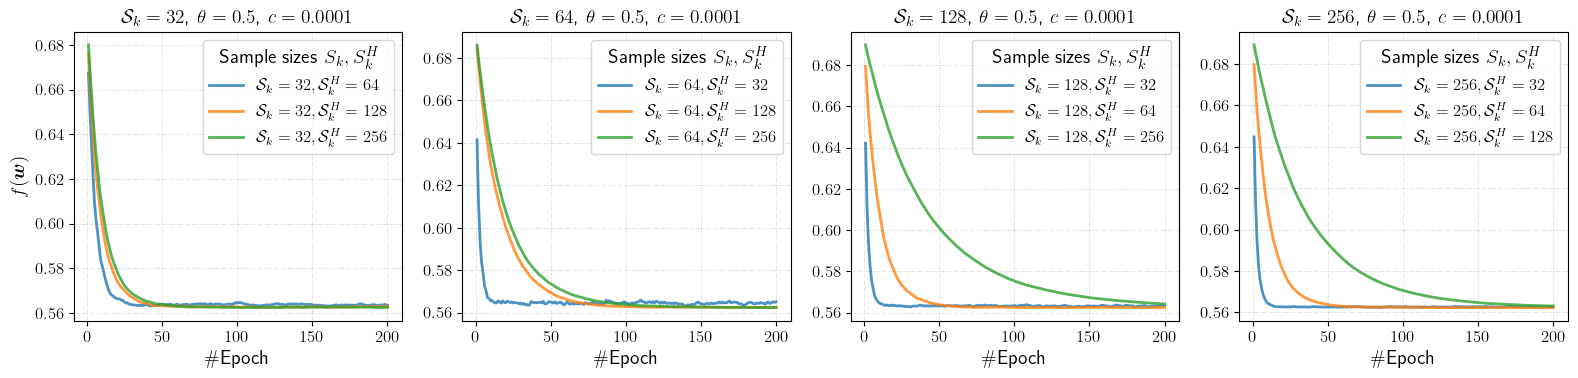

In [23]:
results = {
    32: results_diff_grad_32,
    64: results_diff_grad_64,
    128: results_diff_grad_128,
    256: results_diff_grad_256,
}

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i, (sample_size, results_diff_grad) in enumerate(results.items()):
    for (size_grad, size_hess), (final_point, stats) in results_diff_grad.items():
        ax[i].plot(stats['epochs'], stats['losses'],
                   label=r"$\mathcal{{S}}_{{k}}={}, \mathcal{{S}}_{{k}}^{{H}}={}$".format(size_grad, size_hess),
                   linestyle='-', linewidth=2, alpha=0.8)
    ax[i].set_xlabel(r'\#Epoch')
    ax[i].set_title(r'$\mathcal{S}_k=' + str(sample_size) + r'$, $\theta=0.5$, $c=0.0001$')
    ax[i].legend(fontsize=12, title=r'Sample sizes $S_k, S_k^H$')
    ax[i].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
    if i == 0:
        ax[i].set_ylabel(r'$f(\boldsymbol{w})$')

plt.tight_layout()
plt.savefig('./figures/subsampling_newton_diff_sample_sizes.pdf', bbox_inches='tight')
plt.show()

In [24]:
def calculate_lipschitz_constant(X, sample_indices, lambda_reg):
    X_sample = X[sample_indices]
    n_samples = X_sample.shape[0]
    L = 4 * np.linalg.norm(X_sample.T @ X_sample) / n_samples + lambda_reg
    return L


def calculate_lipschitz_constant_batch(X, sample_indices, lambda_reg, batch_size):
    n_samples = X.shape[0]
    n_batches = n_samples // batch_size
    L = 0
    for i in range(n_batches):
        batch_indices = sample_indices[i * batch_size: (i + 1) * batch_size]
        X_batch = X[batch_indices]
        L += 4 * np.linalg.norm(X_batch.T @ X_batch) / batch_size
    L += lambda_reg
    return L


sample_size_grad = sample_size_hess = 128
L = calculate_lipschitz_constant(problem.X, np.arange(problem.n), problem.lbda)
L_Sk = calculate_lipschitz_constant_batch(problem.X, np.arange(problem.n), problem.lbda, sample_size_grad)
alpha_bar_values = [0.01, 0.05, 0.1, 0.5, 1]
results_alpha_bar, results_alpha_bar_L, results_alpha_bar_L_Sk = {}, {}, {}

# TIME CONSUMING ETA 6min FOR ALL RESULTS FROM EACH ALPHA_BAR

for alpha_bar in alpha_bar_values:
    newton = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                               alpha=alpha_bar)
    final_point, stats = newton.optimize(initial_point, tol=1e-6, use_line_search=True)
    results_alpha_bar[alpha_bar] = (final_point, stats)

for alpha_bar in alpha_bar_values:
    optimizer_fixed = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                                        alpha=alpha_bar / L)
    _, stats_fixed = optimizer_fixed.optimize(w_init=initial_point, tol=1e-6, use_line_search=False)
    results_alpha_bar_L[alpha_bar] = stats_fixed

for alpha_bar in alpha_bar_values:
    optimizer_fixed = SubsamplingNewton(problem, sample_size_grad, sample_size_hess, epochs=200, theta=0.5, c=1e-4,
                                        alpha=alpha_bar / L_Sk)
    _, stats_fixed = optimizer_fixed.optimize(w_init=initial_point, tol=1e-6, use_line_search=False)
    results_alpha_bar_L_Sk[alpha_bar] = stats_fixed

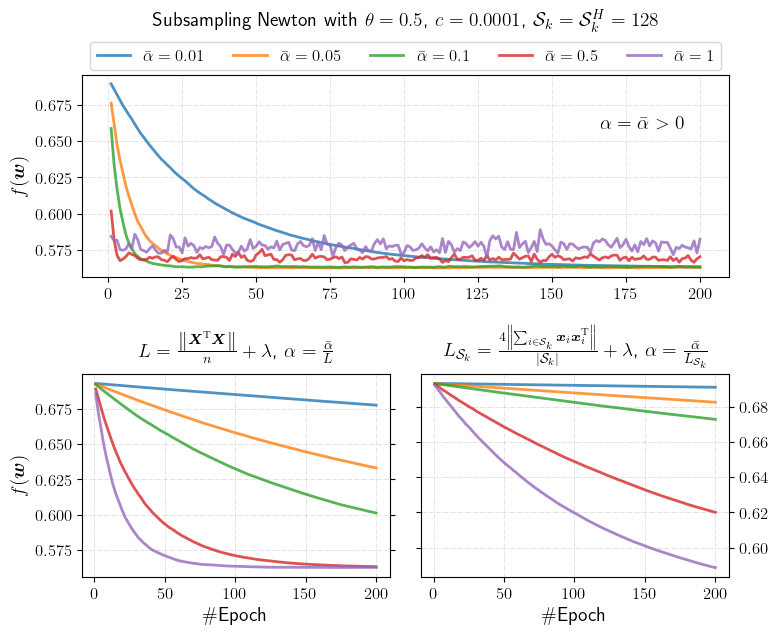

In [25]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0, :])
for alpha, (final_point, stats) in results_alpha_bar.items():
    ax0.plot(stats['epochs'], stats['losses'],
             label=r"$\bar{{\alpha}}={}$".format(alpha),
             linestyle='-', linewidth=2, alpha=0.8)
textstr = r'$\alpha=\bar{\alpha} > 0$'
ax0.text(0.8, 0.8, textstr, transform=ax0.transAxes, fontsize=14, verticalalignment='top')
ax0.set_ylabel(r'$f(\boldsymbol{w})$')
ax0.set_title(r'Subsampling Newton with $\theta=0.5$, $c=0.0001$, $\mathcal{S}_k=\mathcal{S}_k^H=128$', fontsize=14,
              y=1.2, x=0.5)
ax0.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax1 = plt.subplot(gs[1, 0])
for alpha_bar, stats in results_alpha_bar_L.items():
    ax1.plot(stats['epochs'], stats['losses'],
             label=r"$\frac{{\bar{{\alpha}}}}{{L}}={:.6f}$".format(alpha_bar / L),
             linestyle='-', linewidth=2, alpha=0.8)
ax1.set_xlabel(r'\#Epoch')
ax1.set_ylabel(r'$f(\boldsymbol{w})$')
ax1.set_title(
    r'$L=\frac{\left\|\boldsymbol{X}^{\mathrm{T}}\boldsymbol{X}\right\|}{n}+\lambda$, $\alpha=\frac{\bar{\alpha}}{L}$',
    y=1.05)
ax1.tick_params(axis='y', which='both', left=True, right=True, labelleft=True, labelright=False)
ax1.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax2 = plt.subplot(gs[1, 1])
for alpha_bar, stats in results_alpha_bar_L_Sk.items():
    ax2.plot(stats['epochs'], stats['losses'],
             label=r"$\bar{{\alpha}}={}$".format(alpha_bar),
             linestyle='-', linewidth=2, alpha=0.8)
# ax2.set_ylabel(r'$f(\boldsymbol{w})$')
ax2.set_xlabel(r'\#Epoch')
ax2.set_title(
    r'$L_{\mathcal{S}_k}=\frac{4\left\|\sum_{i \in \mathcal{S}_k} \boldsymbol{x}_i \boldsymbol{x}_i^{\mathrm{T}}\right\|}{\left|\mathcal{S}_k\right|}+\lambda$, $\alpha=\frac{\bar{\alpha}}{L_{\mathcal{S}_k}}$',
    y=1.05)
ax2.tick_params(axis='y', which='both', left=True, right=True, labelleft=False, labelright=True)
ax2.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

ax0.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0., 1.1, 1., .102), ncol=7, mode='expand')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./figures/subsampling_newton_combined.pdf', bbox_inches='tight')
plt.show()

In [26]:
alpha = 0.01
problem = pblogreg
initial_point = np.zeros(problem.d)
epochs = 200
tobe_fair_iter = 200 * problem.n

lbfgs = LBFGSOptimizer(problem.fun, problem.grad, initial_point, memory_size=5, c=1e-4, theta=0.5, verbose=False)
_, stats_lbfgs = lbfgs.solve(tolerance=1e-6, max_iterations=tobe_fair_iter)

quasi_newton = QuasiNewtonBFGSOptimizer(problem.fun, problem.grad, initial_point, c=1e-4, theta=0.5, verbose=False)
_, stats_quasi_newton = quasi_newton.solve(tolerance=1e-6, max_iterations=tobe_fair_iter)

sto_bfgs_1 = StochasticBFGS(problem, sample_size=1, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_1 = StochasticLBFGS(problem, sample_size=1, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_16 = StochasticBFGS(problem, sample_size=16, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_16 = StochasticLBFGS(problem, sample_size=16, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_32 = StochasticBFGS(problem, sample_size=32, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_32 = StochasticLBFGS(problem, sample_size=32, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_64 = StochasticBFGS(problem, sample_size=64, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_64 = StochasticLBFGS(problem, sample_size=64, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_128 = StochasticBFGS(problem, sample_size=128, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_128 = StochasticLBFGS(problem, sample_size=128, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)
sto_bfgs_256 = StochasticBFGS(problem, sample_size=256, epochs=epochs, theta=0.5, c=1e-4, alpha=alpha)
sto_lbfgs_256 = StochasticLBFGS(problem, sample_size=256, epochs=epochs, m=5, theta=0.5, c=1e-4, alpha=alpha)

_, stats_sto_bfgs_1 = sto_bfgs_1.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_1 = sto_lbfgs_1.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_16 = sto_bfgs_16.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_16 = sto_lbfgs_16.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_32 = sto_bfgs_32.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_32 = sto_lbfgs_32.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_64 = sto_bfgs_64.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_64 = sto_lbfgs_64.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_128 = sto_bfgs_128.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_128 = sto_lbfgs_128.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_bfgs_256 = sto_bfgs_256.optimize(initial_point, tol=1e-6, use_line_search=True)
_, stats_sto_lbfgs_256 = sto_lbfgs_256.optimize(initial_point, tol=1e-6, use_line_search=True)

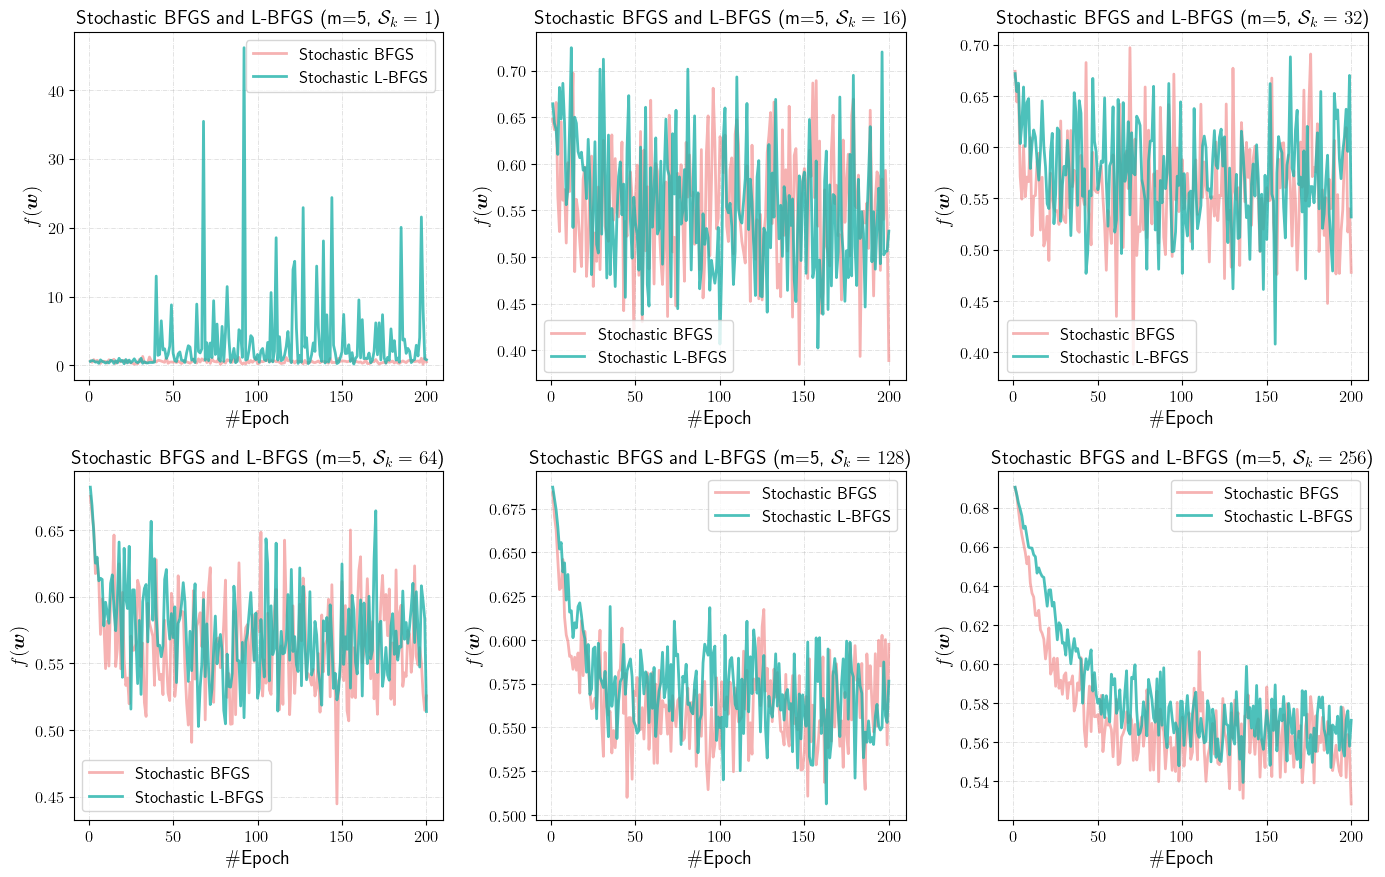

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(14, 9))

for i, (sample_size, stats_sto_bfgs) in enumerate(
        [(1, stats_sto_bfgs_1), (16, stats_sto_bfgs_16), (32, stats_sto_bfgs_32), (64, stats_sto_bfgs_64),
         (128, stats_sto_bfgs_128), (256, stats_sto_bfgs_256)]):
    ax[i // 3, i % 3].plot(stats_sto_bfgs['epochs'], stats_sto_bfgs['losses'],
                           label='Stochastic BFGS', linestyle='-', linewidth=2, alpha=0.6, color='lightcoral')
    ax[i // 3, i % 3].set_xlabel(r'\#Epoch')
    ax[i // 3, i % 3].set_ylabel(r'$f(\boldsymbol{w})$')
    ax[i // 3, i % 3].set_title(r'Stochastic BFGS and L-BFGS (m=5, $\mathcal{{S}}_k={}$)'.format(sample_size))
    ax[i // 3, i % 3].legend(fontsize=12)
    ax[i // 3, i % 3].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

for i, (sample_size, stats_sto_lbfgs) in enumerate(
        [(1, stats_sto_lbfgs_1), (16, stats_sto_lbfgs_16), (32, stats_sto_lbfgs_32), (64, stats_sto_lbfgs_64),
         (128, stats_sto_lbfgs_128), (256, stats_sto_lbfgs_256)]):
    ax[i // 3, i % 3].plot(stats_sto_lbfgs['epochs'], stats_sto_lbfgs['losses'],
                           label='Stochastic L-BFGS', linestyle='-', linewidth=2, alpha=0.8, color='lightseagreen')
    ax[i // 3, i % 3].set_xlabel(r'\#Epoch')
    ax[i // 3, i % 3].set_ylabel(r'$f(\boldsymbol{w})$')
    ax[i // 3, i % 3].set_title(r'Stochastic BFGS and L-BFGS (m=5, $\mathcal{{S}}_k={}$)'.format(sample_size))
    ax[i // 3, i % 3].legend(fontsize=12)
    ax[i // 3, i % 3].grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('./figures/stochastic_bfgs_vs_quasi_newton_batch_sizes.pdf', bbox_inches='tight')
plt.show()

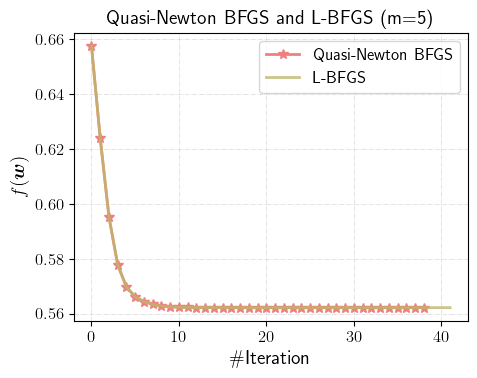

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(stats_quasi_newton['function_values'], label='Quasi-Newton BFGS', linestyle='-', linewidth=2,
        color='lightcoral', marker='*', markersize=7)
ax.plot(stats_lbfgs['function_values'], label='L-BFGS', linestyle='-', linewidth=2, alpha=0.8, color='darkkhaki')
ax.set_xlabel(r'\#Iteration')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Quasi-Newton BFGS and L-BFGS (m=5)')
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/quasi_newton_vs_lbfgs.pdf', bbox_inches='tight')
plt.show()

# Part 3: Binary classification

In [29]:
from instance import Instance

In [30]:
!wget -c https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms

--2024-03-09 13:14:09--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [31]:
lr = Instance(dataset_path="mushrooms")

In [32]:
n_features = lr.d
n_samples = lr.n
print(f"Number of samples: {n_samples}, number of features: {n_features}")

Number of samples: 8124, number of features: 112


In [33]:
import time

start_point = np.zeros(lr.d)
sample_size = 256
epochs = 200
alpha = 0.001
subsampled_newton = SubsamplingNewton(lr, sample_size, sample_size, epochs, theta=0.5, c=1e-4, alpha=alpha,
                                      verbose=False)
stochastic_bfgs = StochasticBFGS(lr, sample_size, epochs, theta=0.5, c=1e-4, alpha=alpha, verbose=False)

execution_times = []
start = time.time()
final_point, stats_newton = subsampled_newton.optimize(start_point, tol=1e-6, use_line_search=True)
execution_times.append(time.time() - start)
start = time.time()
final_point, stats_bfgs = stochastic_bfgs.optimize(start_point, tol=1e-6, use_line_search=True)
execution_times.append(time.time() - start)

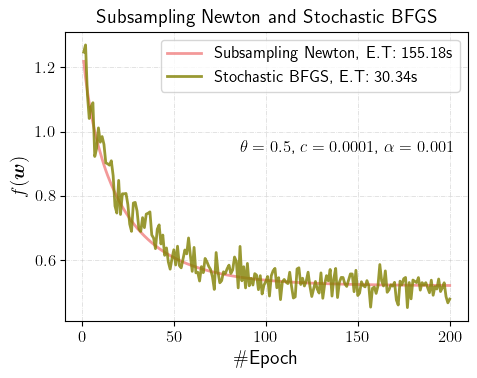

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(stats_newton['epochs'], stats_newton['losses'], label=f'Subsampling Newton, E.T: {execution_times[0]:.2f}s',
        linestyle='-', linewidth=2,
        alpha=0.8,
        color='lightcoral')
ax.plot(stats_bfgs['epochs'], stats_bfgs['losses'], label=f'Stochastic BFGS, E.T: {execution_times[1]:.2f}s',
        linestyle='-', linewidth=2, alpha=0.8,
        color='olive')
ax.annotate(r'$\theta=0.5$, $c=0.0001$, $\alpha=0.001$', xy=(0.7, 0.6), xycoords='axes fraction', fontsize=12,
            ha='center', va='center')
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Subsampling Newton and Stochastic BFGS')
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton_vs_stochastic_bfgs.pdf', bbox_inches='tight')
plt.show()

In [35]:
start_point = np.zeros(lr.d)
sample_size = 256
epochs = 200
alpha = [0.0001, 0.001, 0.005, 0.01, 0.05]
results = {}

In [ ]:
# TIME CONSUMING ETA 33min FOR ALL RESULTS FROM EACH ALPHA
for alpha_value in alpha:
    subsampled_newton = SubsamplingNewton(lr, sample_size, sample_size, epochs, theta=0.5, c=1e-4, alpha=alpha_value)
    final_point, stats = subsampled_newton.optimize(start_point, tol=1e-6, use_line_search=True)
    results[alpha_value] = (final_point, stats)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
for alpha_value, (final_point, stats) in results.items():
    ax.plot(stats['epochs'], stats['losses'], label=f"$\\alpha={alpha_value}$", linestyle='-', linewidth=2, alpha=0.8)
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Subsampling Newton with $\theta=0.5$, $c=0.0001$')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton_alpha.pdf', bbox_inches='tight')
plt.show()

In [ ]:
result_bfgs = {}
for alpha_value in alpha:
    stocharistic_bfgs = StochasticBFGS(lr, sample_size, epochs, theta=0.5, c=1e-4, alpha=alpha_value)
    final_point, stats = stocharistic_bfgs.optimize(start_point, tol=1e-6, use_line_search=True)
    result_bfgs[alpha_value] = (final_point, stats)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
colors = ['lightcoral', 'olive', 'lightseagreen', 'darkkhaki', 'lightcoral']
for i, (alpha_value, (final_point, stats)) in enumerate(result_bfgs.items()):
    ax.plot(stats['epochs'], stats['losses'], label=f"$\\alpha={alpha_value}$", linestyle='-', color=colors[i])
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'Stochastic BFGS with $\theta=0.5$, $c=0.0001$')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/stochastic_bfgs_alpha.pdf', bbox_inches='tight')
plt.show()

# Optional

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

In [ ]:
!wget -c https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

In [ ]:
X, y = load_svmlight_file("a9a")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_instance = Instance(X=X_train.toarray(), y=y_train)
test_instance = Instance(X=X_test.toarray(), y=y_test)

dim_table = PrettyTable()
name_dataset = "A9A"
print(f"{name_dataset} Dataset")
dim_table.field_names = [f"Dataset: {name_dataset}", "Train", "Test"]
dim_table.add_row(["Features", train_instance.d, test_instance.d])
dim_table.add_row(["Samples", train_instance.n, test_instance.n])
print(dim_table)

In [ ]:
start_point = np.zeros(train_instance.d)
sample_size = 256
epochs = 100
learning_rate = 0.001

stochastic_bfgs = StochasticBFGS(train_instance, sample_size=sample_size, epochs=epochs, theta=0.5, c=1e-4,
                                 alpha=learning_rate,
                                 verbose=False)
w_final_bfgs, stats_bfgs = stochastic_bfgs.optimize(start_point, tol=1e-6, use_line_search=True)
subsampled_newton = SubsamplingNewton(train_instance, sample_size, sample_size, epochs, theta=0.5, c=1e-4,
                                      alpha=learning_rate,
                                      verbose=False)
w_final_newton, stats_newton = subsampled_newton.optimize(start_point, tol=1e-6, use_line_search=True)

In [ ]:
train_loss_bfgs = np.mean([train_instance.f_i(i, w_final_bfgs) for i in range(train_instance.n)])
test_loss_bfgs = np.mean([test_instance.f_i(i, w_final_bfgs) for i in range(test_instance.n)])
train_loss_newton = np.mean([train_instance.f_i(i, w_final_newton) for i in range(train_instance.n)])
test_loss_newton = np.mean([test_instance.f_i(i, w_final_newton) for i in range(test_instance.n)])
table = PrettyTable()
table.field_names = ["Dataset: A9A", "Subsampling Newton", "Stochastic BFGS"]
table.add_row(["Train Loss", train_loss_newton.round(4), train_loss_bfgs.round(4)])
table.add_row(["Test Loss", test_loss_newton.round(4), test_loss_bfgs.round(4)])
print(table)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(stats_bfgs['epochs'], stats_bfgs['losses'], label='Stochastic BFGS', linestyle='-', linewidth=2,
        color='lightcoral')
ax.plot(stats_newton['epochs'], stats_newton['losses'], label='Subsampling Newton', linestyle='-', linewidth=2,
        color='olivedrab')
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$f(\boldsymbol{w})$')
ax.set_title(r'A9A Dataset: $\alpha={}$, fixed $\theta={}$, $c={}$'.format(learning_rate, subsampled_newton.theta,
                                                                           subsampled_newton.c))
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton_vs_stochastic_bfgs_a9a.pdf', bbox_inches='tight')
plt.show()

In [ ]:
y_pred_bfgs = np.array(
    [1 if train_instance.sigmoid(np.dot(w_final_bfgs, train_instance.X[i])) > 0.5 else -1 for i in
     range(train_instance.n)])
y_pred_newton = np.array(
    [1 if train_instance.sigmoid(np.dot(w_final_newton, train_instance.X[i])) > 0.5 else -1 for i in
     range(train_instance.n)])

accuracy_bfgs, f1_bfgs, precision_bfgs, recall_bfgs = accuracy_score(train_instance.y, y_pred_bfgs), f1_score(
    train_instance.y, y_pred_bfgs), precision_score(train_instance.y, y_pred_bfgs), recall_score(train_instance.y,
                                                                                                 y_pred_bfgs)
accuracy_newton, f1_newton, precision_newton, recall_newton = accuracy_score(train_instance.y, y_pred_newton), f1_score(
    train_instance.y, y_pred_newton), precision_score(train_instance.y, y_pred_newton), recall_score(train_instance.y,
                                                                                                     y_pred_newton)

table = PrettyTable()
table.field_names = ["Dataset: W1A", "Subsampling Newton", "Stochastic BFGS"]
table.add_row(["Accuracy", accuracy_newton.round(4), accuracy_bfgs.round(4)])
table.add_row(["F1 Score", f1_newton.round(4), f1_bfgs.round(4)])
table.add_row(["Precision", precision_newton.round(4), precision_bfgs.round(4)])
table.add_row(["Recall", recall_newton.round(4), recall_bfgs.round(4)])
print(table)

In [ ]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_instance = Instance(X=X_train, y=y_train)
test_instance = Instance(X=X_test, y=y_test)

In [ ]:
start_point = np.zeros(train_instance.d)
sample_size = 256
epochs = 500
learning_rate = 0.005

In [ ]:
stochastic_bfgs = StochasticBFGS(train_instance, sample_size=sample_size, epochs=epochs, theta=0.5, c=1e-4,
                                 alpha=learning_rate,
                                 verbose=True)
w_final_bfgs, stats_bfgs = stochastic_bfgs.optimize(start_point, tol=1e-6, use_line_search=True)

subsampled_newton = SubsamplingNewton(train_instance, sample_size, sample_size, epochs, theta=0.5, c=1e-4,
                                      alpha=learning_rate,
                                      verbose=True)
w_final_newton, stats_newton = subsampled_newton.optimize(start_point, tol=1e-6, use_line_search=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(stats_bfgs['epochs'], stats_bfgs['losses'], label='Stochastic BFGS', linestyle='-', linewidth=2,
        color='lightsalmon')
ax.plot(stats_newton['epochs'], stats_newton['losses'], label='Subsampling Newton', linestyle='-', linewidth=2,
        color='seagreen')
ax.set_xlabel(r'\#Epoch')
ax.set_ylabel(r'$\mathcal{L}(\boldsymbol{w})$')
ax.set_title(
    r'Make Moons Dataset: $\alpha={}$, fixed $\theta={}$, $c={}$'.format(learning_rate, subsampled_newton.theta,
                                                                         subsampled_newton.c))
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig('./figures/subsampling_newton_vs_stochastic_bfgs_moons.pdf', bbox_inches='tight')
plt.show()

In [ ]:
y_pred_bfgs = np.array(
    [1 if train_instance.sigmoid(np.dot(w_final_bfgs, train_instance.X[i])) > 0.5 else 0 for i in
     range(train_instance.n)])
y_pred_newton = np.array(
    [1 if train_instance.sigmoid(np.dot(w_final_newton, train_instance.X[i])) > 0.5 else 0 for i in
     range(train_instance.n)])

accuracy_bfgs, f1_bfgs, precision_bfgs, recall_bfgs = accuracy_score(train_instance.y, y_pred_bfgs), f1_score(
    train_instance.y, y_pred_bfgs), precision_score(train_instance.y, y_pred_bfgs), recall_score(train_instance.y,
                                                                                                 y_pred_bfgs)

accuracy_newton, f1_newton, precision_newton, recall_newton = accuracy_score(train_instance.y, y_pred_newton), f1_score(
    train_instance.y, y_pred_newton), precision_score(train_instance.y, y_pred_newton), recall_score(train_instance.y,
                                                                                                     y_pred_newton)

table = PrettyTable()
table.field_names = ["Dataset: Make Moons", "Subsampling Newton", "Stochastic BFGS"]
table.add_row(["Accuracy", accuracy_newton.round(4), accuracy_bfgs.round(4)])
table.add_row(["F1 Score", f1_newton.round(4), f1_bfgs.round(4)])
table.add_row(["Precision", precision_newton.round(4), precision_bfgs.round(4)])
table.add_row(["Recall", recall_newton.round(4), recall_bfgs.round(4)])
print(table)